In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
from src.preprocess_baseline import *
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [9]:
features = ["Edit_Distance", "Mean_IKI","Var_IKI"]
num_folds = 10
data_root = Path('../data')

In [49]:
def baseline_fold_experiment(data_df,fold_df,name='lol_lol'):
    data_df.Participant_ID = data_df.Participant_ID.astype('int64')
    merged_df=pd.merge(data_df,fold_df, how = 'inner', left_on = ['Participant_ID','Sentence_ID'], right_on = ['Patient_ID','Sentence_ID'])

    interp_tpr=[]
    AUC = []
    x = np.linspace(0,1,100)
    lw = 2
    for fold_idx in range(0,10):
        test_mask = merged_df.fold == fold_idx
        train_mask = merged_df.fold != fold_idx

        x_train = merged_df.loc[train_mask,features].values
        x_test = merged_df.loc[test_mask,features].values

        y_train = merged_df.loc[train_mask,'Diagnosis'].values
        y_test = merged_df.loc[test_mask,'Diagnosis'].values
    

        clf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
        clf.fit(x_train,y_train)
        p_test = clf.predict_proba(x_test)
        pred = clf.predict(x_test)
        fpr, tpr, _ = roc_curve(y_test, p_test[:,1])
        interp_tpr.append(np.interp(x,xp=fpr,fp=tpr))
        roc_auc = auc(fpr, tpr)
        #print(fold_idx , ': ',roc_auc)
        #print('acc:', np.sum(pred == y_test) / y_test.size)
        AUC.append(roc_auc)
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw -1, alpha = 0.3)

    mean = np.mean(interp_tpr,axis=0)
    std = np.std(interp_tpr,axis = 0)    
    plt.plot(x, mean , color = 'darkorange', lw=lw, label = 'AUC: {:.2f} ({:.2f}), best: {:.2}'.format(np.mean(AUC),np.std(AUC),np.max(AUC)))
    plt.fill_between(x,mean + std, mean - std, alpha = 0.2, color = 'darkorange')    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.savefig('plots/' + name.replace(' ','_') + '.png')
    plt.show()
    return merged_df

## MJFF [english: sentence level]

In [50]:
df = pd.read_csv(data_root / 'MJFF' / 'EnglishData-duplicateeventsremoved.csv')
df_meta = pd.read_csv(data_root / 'MJFF'/ 'EnglishParticipantKey.csv',
                      header=0,
                      names=["participant_id", "ID", "attempt", "diagnosis"],
                     )

random_fold = pd.read_csv('folds/MJFF_EnglishData_attempt_1_fold.csv')
subject_fold = pd.read_csv('folds/MJFF_EnglishData_attempt_1_subject_lvl_fold.csv')

In [51]:

which_attempt = 1
# No changes have been made
df_baselines_raw = calculate_iki_and_ed_baseline(df=df,
                                                 df_meta=df_meta,
                                                 which_dataset='mjff_english',
                                                 drop_shift=False,
                                                 attempt=which_attempt,
                                                 invokation_type=-1)
# Error corrections have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df=df,
                                                    df_meta=df_meta,
                                                    which_dataset='mjff_english',
                                                    drop_shift=False,
                                                    attempt=which_attempt,
                                                    invokation_type=1)

#df_baselines_edited.Participant_ID = df_baselines_edited.Participant_ID.astype('int64')

MJFF


C:\Users\Mathias\repos\habitual_errors_NLP\experimental\..\src\preprocess_baseline.py:138: RuntimeWarning: Mean of empty slice.
  data.append((participant, sentence, diagnosis, iki.mean(), iki.var(), ed))
C:\Users\Mathias\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Mathias\repos\habitual_errors_NLP\experimental\..\src\preprocess_baseline.py:138: RuntimeWarning: Degrees of freedom <= 0 for slice
  data.append((participant, sentence, diagnosis, iki.mean(), iki.var(), ed))
C:\Users\Mathias\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Mathias\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MJFF


,Participant_ID,Sentence_ID,Diagnosis,Mean_IKI,Var_IKI,Edit_Distance
0,1,55,1,322.153153,102710.760328,1
1,2,55,0,545.215010,331749.817392,8
2,4,55,1,320.894737,117057.778393,4
3,5,55,0,412.524427,127264.852693,8
4,6,55,1,482.232143,194630.267538,4


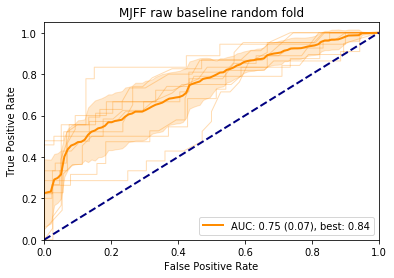

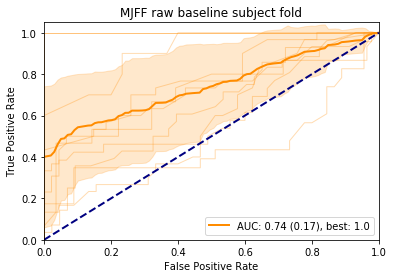

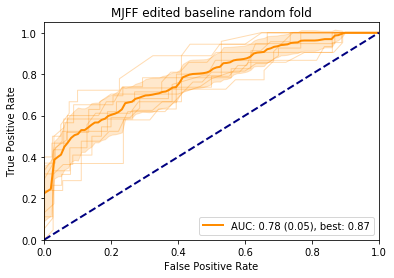

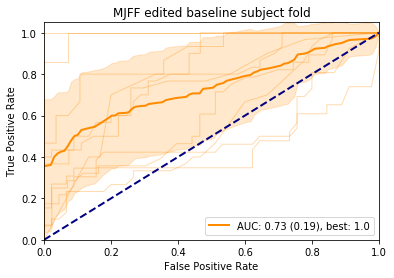

In [54]:
baseline_fold_experiment(data_df = df_baselines_raw,fold_df = random_fold ,name='MJFF raw baseline random fold')
baseline_fold_experiment(data_df = df_baselines_raw,fold_df = subject_fold ,name='MJFF raw baseline subject fold')

baseline_fold_experiment(data_df = df_baselines_edited,fold_df = random_fold ,name='MJFF edited baseline random fold')
mdf = baseline_fold_experiment(data_df = df_baselines_edited,fold_df = subject_fold ,name='MJFF edited baseline subject fold')

# MRC [English]

In [68]:
random_fold = pd.read_csv('folds/MRC_EnglishData_attempt_1_fold.csv')
subject_fold = pd.read_csv('folds/MRC_EnglishData_attempt_1_subject_lvl_fold.csv')

In [64]:


df = pd.read_pickle(data_root / 'MRC' / 'processed_mrc_dataset.pkl')
df.drop(df.index[(df.type == "keyup")], inplace=True)
# Reset index so that we can sort it properly in the next step
df.reset_index(drop=True, inplace=True)
# In-place dropping of these rows
df.drop(df.index[(df.key == "β")], inplace=True)
# Reset index so that we can sort it properly in the next step
df.reset_index(drop=True, inplace=True)


df_baselines_raw = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)],
                                                 which_dataset='mrc',
                                                 drop_shift=True, 
                                                 invokation_type=-1) # No changes have been made
df = pd.read_pickle(data_root / 'MRC' / 'processed_mrc_dataset.pkl')
df_baselines_edited = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)],
                                                    which_dataset='mrc',
                                                    drop_shift=True, 
                                                    invokation_type=1) # Error corrections have been made

MRC


C:\Users\Mathias\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


MRC


C:\Users\Mathias\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


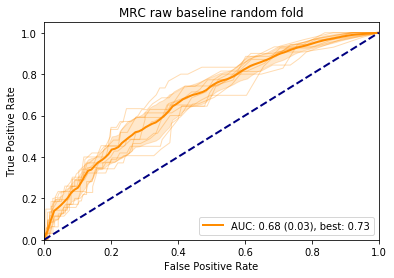

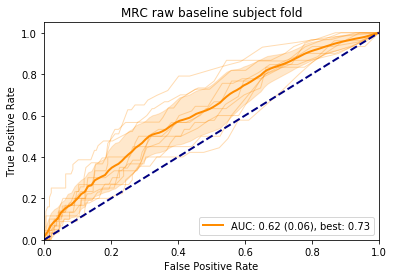

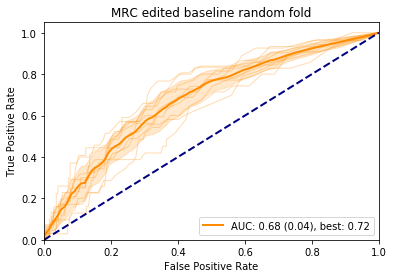

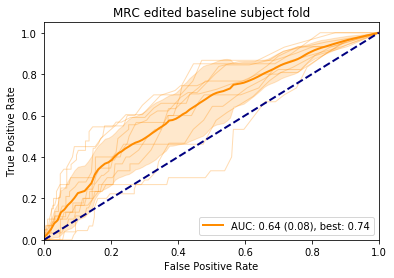

In [69]:
baseline_fold_experiment(data_df = df_baselines_raw,fold_df = random_fold ,name='MRC raw baseline random fold')
baseline_fold_experiment(data_df = df_baselines_raw,fold_df = subject_fold ,name='MRC raw baseline subject fold')

baseline_fold_experiment(data_df = df_baselines_edited,fold_df = random_fold ,name='MRC edited baseline random fold')
mdf = baseline_fold_experiment(data_df = df_baselines_edited,fold_df = subject_fold ,name='MRC edited baseline subject fold')